In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [3]:
# Read/write directory parameters
#*************************************
datadir = 'data/synth64_76/dataset'
paramdir = 'data/synth64_76/dataparams'
savemodeldir = 'model'
loadmodelpath = 'model/2018-10-12_20-14-50_model_epoch1_step2100.pth'

# Pytorch parameters
#*************************************
#--- Note all intervals below are counted in no. of steps. 1 epoch = [len(dataset)//batch_size] steps ---

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
savemodel = True
savemodel_interval = 0  #if 0 (and savemodel=True) will only save model at the end of entire training
loadmodel = False

# Training parameters
#*************************************
sr = 16000
seqLen = 256
stride = 10
batch_size = 64
num_epochs = 1
lr = 0.005
log_interval = 25
max_steps = 1000 #set max_steps > (len(dataset)//batch_size) if training for more than 1 epoch
teacher_forcing_ratio = 1 #stochastically use either targets or own predictions as input for training. Set to 1 to always use targets

#Generation parameters
#*************************************
max_length = seqLen
evaluate_interval = 50

print(device, torch.version.cuda)

cuda:0 9.0


In [4]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'instID', 'amplitude', 'midiPitch'])


In [5]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(256,0,1) #initialize the mu-law encodings
targetcoding = mulaw(256)
rescalePitch = normalizeDim('midiPitch',64,76)
rescaleAmp = normalizeDim('amplitude',0,0.9)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID','amplitude','midiPitch'],
                                  transform=transform.Compose([injectNoise(weight=0.1),audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID','amplitude','midiPitch'],
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

size of dataset is 1248000
no. of steps per epoch is 19500
(256, 1)


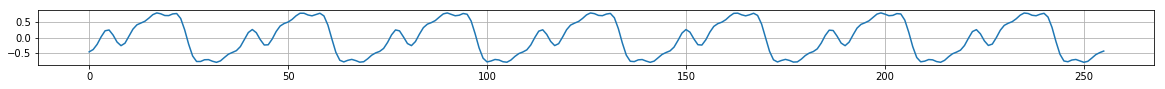

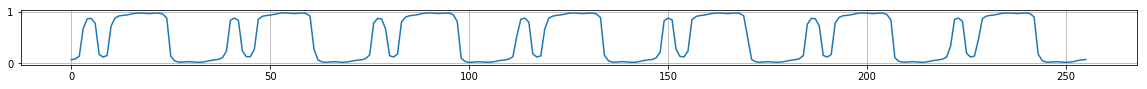

In [6]:
print("size of dataset is",len(adataset))
print("no. of steps per epoch is",len(adataset)//batch_size)

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = audiocoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

In [7]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - 1 
    # output size - mulaw bins
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden, batch_size=1):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(batch_size,-1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, cond_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)

    def forward(self, input, hidden, batch_size=1):
        lin1 = self.i2h(input).view(batch_size,1,-1)
        output, hidden = self.gru(lin1, hidden) #output shape:[batch_size,1,hidden_size] hidden shape:[n_layers,batch_size,hidden_size]
        return output, hidden

    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, input_size, cond_size, hidden_size, output_size, dropout_p=0.1, max_length=seqLen):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.i2h = nn.Linear(input_size+cond_size, hidden_size) 
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, batch_size=1):
        embedded = self.i2h(input)
        embedded = self.dropout(embedded)
        #print("size of embedded is " + str(embedded.size()))  #[batch_size,hidden_size]
        #print("size of hidden is " + str(hidden.size())) #hidden shape:[n_layers,batch_size,hidden_size]
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded, hidden[0]), 1)), dim=1).view(batch_size, 1, -1)  
        #print("size of attn_weights is " + str(attn_weights.size()))
        #print("size of encoder_outputs is " + str(encoder_outputs.size()))
        attn_applied = torch.bmm(attn_weights,     #attn_weights:[batch_size,1,seqLen]
                                 encoder_outputs)  #encoder_outputs:[batch_size,seqLen,hidden_size]
                                                    #attn_applied:[batch_size,1,hidden_size]

        #print("size of attn_applied is " + str(attn_applied.size()))
        output = torch.cat((embedded, attn_applied.squeeze(1)), 1)
        #print("size of output is " + str(output.size()))
        output = self.attn_combine(output).view(batch_size,1,-1)
        #print("size of attn_combine is " + str(output.size()))

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        #print("size of gru out is " + str(output.size()))

        output = self.out(output.view(batch_size,-1))
        #print("size of final is " + str(output.size()))
        return output, hidden, attn_weights

    def init_hidden(self,batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, dtype=torch.float, device=device)

In [9]:
# Define the training cycle (100% teacher forcing for now)
#*************************************
def train(encoder,decoder,epoch):
    encoder.train() #put in training mode
    decoder.train() 
    ave_loss_over_steps = 0
    
    for step, (inp,target) in enumerate(train_loader):
        inp, target = inp.to(device), target.to(device)
        #print(inp.shape)

        # Forward + Backward + Optimize
        encoder_hidden = encoder.init_hidden(batch_size)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        encoder_outputs = torch.zeros(batch_size, seqLen, encoder.hidden_size, device=device)

        loss = 0
        
        for i in range(seqLen):
            encoder_output, encoder_hidden = encoder(inp[:,i,:],encoder_hidden,batch_size)
            #print("out",encoder_output.shape)
            #print(encoder_output)
            #print("hidden",encoder_hidden.shape)
            #print("encoderout",encoder_output[:,0].shape)
            #print(encoder_output[0,0])
            encoder_outputs[:,i] = encoder_output[:,0]
            
        decoder_hidden = encoder_hidden[0].unsqueeze(0)
        #print("decoder_hidden",decoder_hidden.shape)
        
        use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio or i==0 else False
        #similar to Bengio et al, Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks

        for i in range(seqLen):
            if use_teacher_forcing: #feed the target as the next input
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        inp[:,i,:],decoder_hidden,encoder_outputs,batch_size)  #input dim: (batch, seq, feature)
                    loss += criterion(decoder_output, torch.squeeze(target[:,i],1))

                    outputs = nn.functional.log_softmax(decoder_output,dim=1)
                    topv, topi = outputs.detach().topk(1)  #choose the strongest activation detach()
                    predicted_sample = targetcoding.index2float(topi)
                    #print(predicted_sample.shape)

            else: #feed its own predictions as next input
                #print("before",inp[:,i,:].shape)
                own_inp = inp[:,i,:].clone()
                own_inp[:,0] = torch.squeeze(torch.tensor(audiocoding(predicted_sample),
                                                          dtype=torch.float,device=device,requires_grad=True),1)
                #print("after",inp[:,i,:])
                #print("after own",own_inp)
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    inp[:,i,:],decoder_hidden,encoder_outputs,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(decoder_output, torch.squeeze(target[:,i],1))

                outputs = nn.functional.log_softmax(decoder_output,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation
                predicted_sample = targetcoding.index2float(topi)
       
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
     
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        
        if (step+1) % log_interval == 0:
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch+1, num_epochs, step+1, len(adataset)//batch_size, ave_loss_over_steps/log_interval))
            
            list_of_losses.append(ave_loss_over_steps/log_interval)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result, attentions = generate(encoder,decoder,max_length)
            plt.figure(figsize=(20,1)) 
            plt.plot(np.arange(len(result)), result) #just print one example from the batch
            plt.show()
            plt.matshow(attentions.numpy())
            plt.show()
            encoder.train()
            decoder.train()  #put model back to training mode
        
        if savemodel_interval != 0 and savemodel:
            if (step+1) % savemodel_interval == 0:
                torch.save(encoder.state_dict(), 
                   '{}/{:%Y-%m-%d_%H-%M-%S}_encoder_epoch{}_step{}.pth'.format(savemodeldir,datetime.now(),epoch+1,step+1))
                print('model saved at epoch{} step{}'.format(epoch+1,step+1))
                torch.save(decoder.state_dict(), 
                   '{}/{:%Y-%m-%d_%H-%M-%S}_decoder_epoch{}_step{}.pth'.format(savemodeldir,datetime.now(),epoch+1,step+1))
                print('model saved at epoch{} step{}'.format(epoch+1,step+1))
        
        if step==max_steps:
            break
         
        
        
def generate(encoder, decoder,max_length,primer=None,paramvect=None):
    """primer is not None condition, paramvect is incomplete""" 
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        if primer is not None:
            seq = primer
            p_inp = array2tensor(torch.FloatTensor)(audiocoding(primer))
        else:
            for p_inp,target in test_loader:
                seq = np.copy(p_inp[0,:,0])  #extract the original sample
                seq_mu = audiocoding(seq)  #mu-law
                p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
                break   
        generated = seq
        p_inp = p_inp.to(device)
        #print("p_inp",p_inp)

        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(1,max_length, encoder.hidden_size, device=device) #batch_size=1
        
        for j in range(seqLen-1):  #build up hidden state
            encoder_output, encoder_hidden = encoder(p_inp[:,j,:],encoder_hidden)
            encoder_outputs[:,j] = encoder_output[:,0]
            
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        decoder_hidden = encoder_hidden[0].unsqueeze(0)
        
        decoder_attentions = torch.zeros(max_length, max_length)
        #print("inp",inp)
        
        for i in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                        inp,decoder_hidden,encoder_outputs)
            #outputs, hidden = model(inp,hidden)
            #print("att",decoder_attentions)
            
            decoder_attentions[i] = decoder_attention.data
            #print("att2",decoder_attentions)
            
            outputs = nn.functional.log_softmax(decoder_output,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            #print(topv,topv.shape)
            #print(topi,topi.shape)
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.FloatTensor).to(device)
            if paramvect is not None:
                inp[:,1:] = paramvect
                             
        return generated, decoder_attentions
        

In [10]:
# Initialize the network, optimizer and objective func
#*************************************
encoder = EncoderRNN(input_size=1,cond_size=3,hidden_size=40,n_layers=4).to(device)
decoder = AttnDecoderRNN(input_size=1,cond_size=3,hidden_size=40,output_size=256).to(device)
if loadmodel: # load checkpoint if needed
    print("Loading existing checkpoint...")
    encoder.load_state_dict(torch.load(loadmodelpath))
    decoder.load_state_dict(torch.load(loadmodelpath))
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

2018-11-19 22:42:06 Starting training...
2018-11-19 22:43:26 Epoch [1/1], Step [25/19500] Loss: 5.0568
2018-11-19 22:44:42 Epoch [1/1], Step [50/19500] Loss: 4.7444


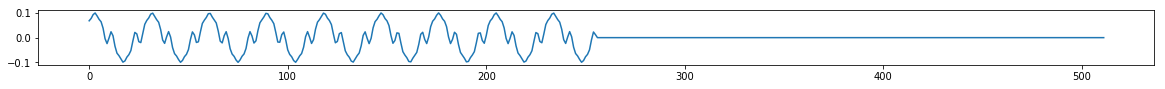

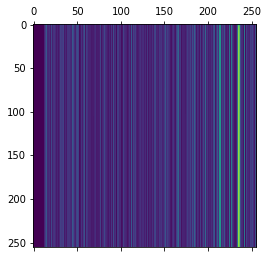

2018-11-19 22:46:01 Epoch [1/1], Step [75/19500] Loss: 4.3063
2018-11-19 22:47:17 Epoch [1/1], Step [100/19500] Loss: 4.0252


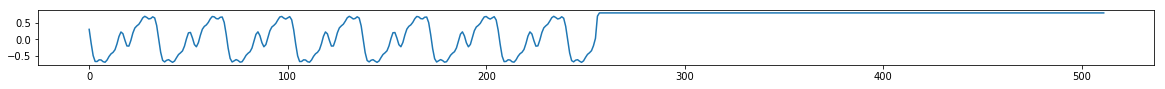

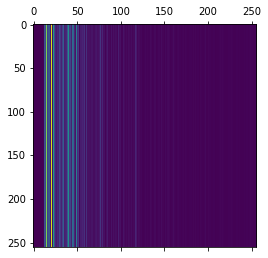

2018-11-19 22:48:37 Epoch [1/1], Step [125/19500] Loss: 3.9493
2018-11-19 22:49:52 Epoch [1/1], Step [150/19500] Loss: 3.7906


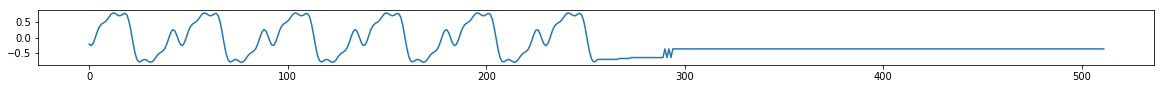

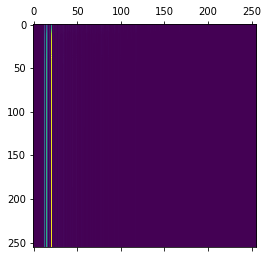

2018-11-19 22:51:11 Epoch [1/1], Step [175/19500] Loss: 3.5440
2018-11-19 22:52:27 Epoch [1/1], Step [200/19500] Loss: 3.5867


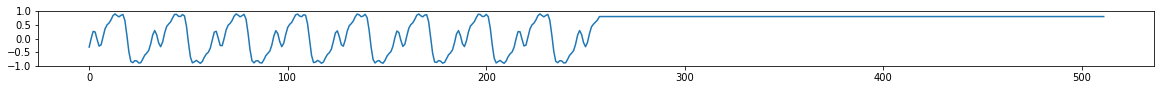

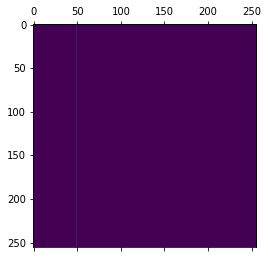

2018-11-19 22:53:46 Epoch [1/1], Step [225/19500] Loss: 3.4551
2018-11-19 22:55:01 Epoch [1/1], Step [250/19500] Loss: 3.3797


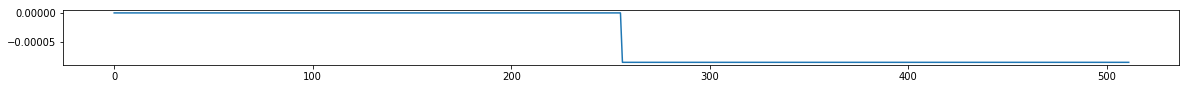

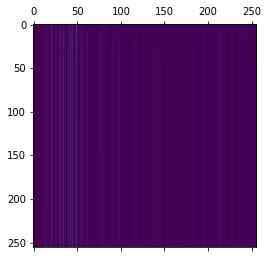

2018-11-19 22:56:20 Epoch [1/1], Step [275/19500] Loss: 3.3279
2018-11-19 22:57:36 Epoch [1/1], Step [300/19500] Loss: 3.1501


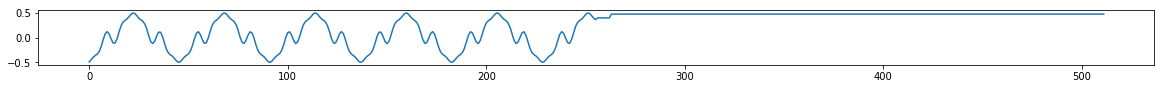

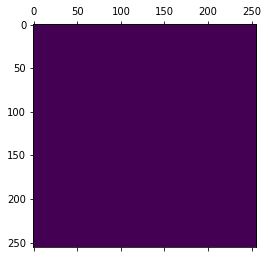

2018-11-19 22:58:56 Epoch [1/1], Step [325/19500] Loss: 3.1249
2018-11-19 23:00:11 Epoch [1/1], Step [350/19500] Loss: 3.1158


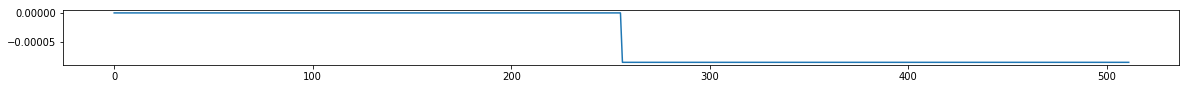

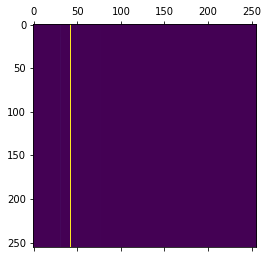

2018-11-19 23:01:30 Epoch [1/1], Step [375/19500] Loss: 3.0207
2018-11-19 23:02:46 Epoch [1/1], Step [400/19500] Loss: 3.0104


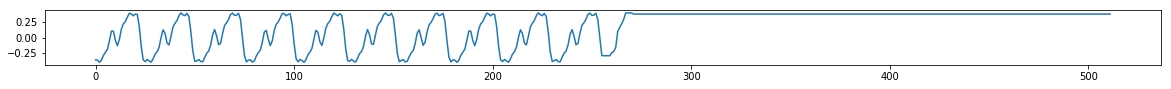

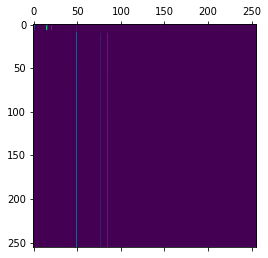

2018-11-19 23:04:07 Epoch [1/1], Step [425/19500] Loss: 2.9600
2018-11-19 23:05:23 Epoch [1/1], Step [450/19500] Loss: 2.9147


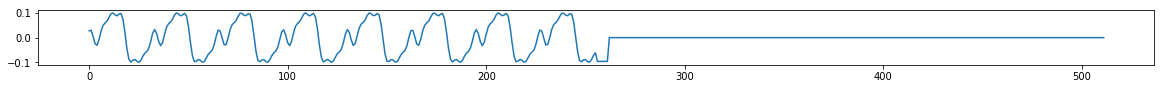

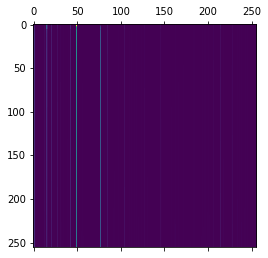

2018-11-19 23:06:42 Epoch [1/1], Step [475/19500] Loss: 2.8837
2018-11-19 23:07:57 Epoch [1/1], Step [500/19500] Loss: 2.8534


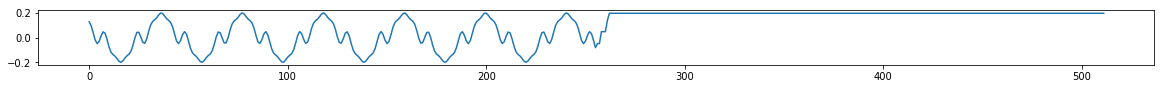

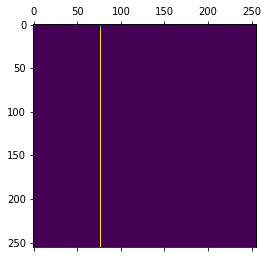

2018-11-19 23:09:16 Epoch [1/1], Step [525/19500] Loss: 2.8166
2018-11-19 23:10:32 Epoch [1/1], Step [550/19500] Loss: 2.7877


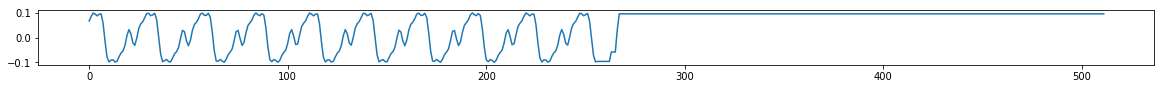

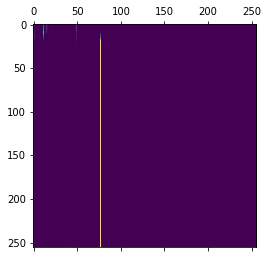

2018-11-19 23:11:51 Epoch [1/1], Step [575/19500] Loss: 2.7922
2018-11-19 23:13:08 Epoch [1/1], Step [600/19500] Loss: 2.7309


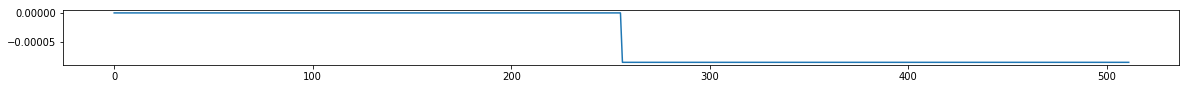

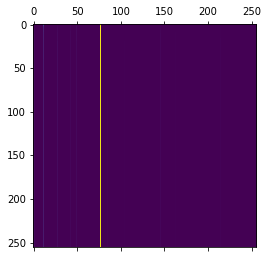

2018-11-19 23:14:26 Epoch [1/1], Step [625/19500] Loss: 2.7015
2018-11-19 23:15:42 Epoch [1/1], Step [650/19500] Loss: 2.7042


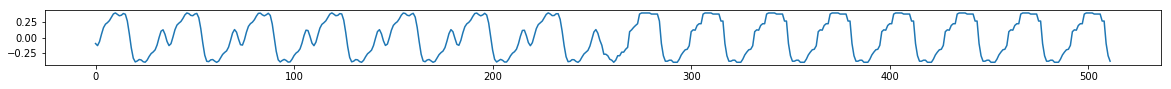

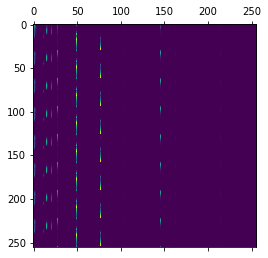

2018-11-19 23:17:01 Epoch [1/1], Step [675/19500] Loss: 2.6764
2018-11-19 23:18:17 Epoch [1/1], Step [700/19500] Loss: 2.6745


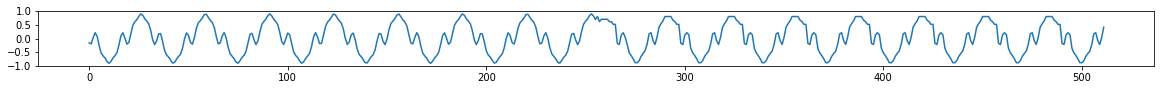

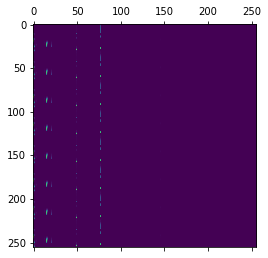

2018-11-19 23:19:36 Epoch [1/1], Step [725/19500] Loss: 2.6310
2018-11-19 23:20:52 Epoch [1/1], Step [750/19500] Loss: 2.5823


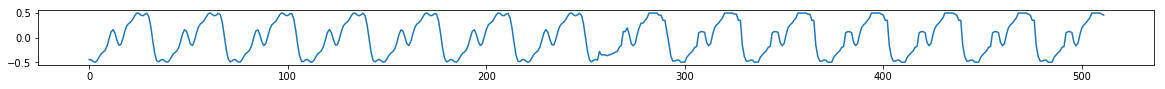

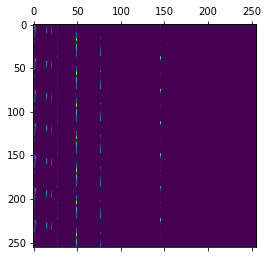

2018-11-19 23:22:11 Epoch [1/1], Step [775/19500] Loss: 2.5963
2018-11-19 23:23:27 Epoch [1/1], Step [800/19500] Loss: 2.5702


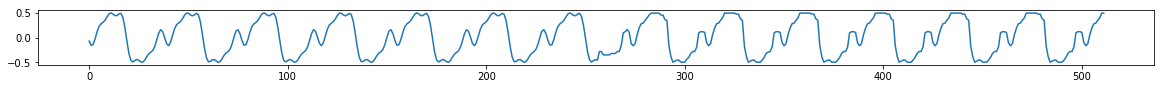

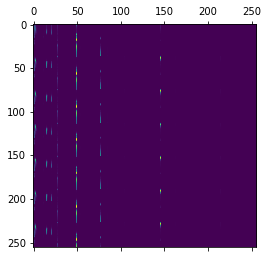

2018-11-19 23:24:46 Epoch [1/1], Step [825/19500] Loss: 2.6328
2018-11-19 23:26:01 Epoch [1/1], Step [850/19500] Loss: 2.5935


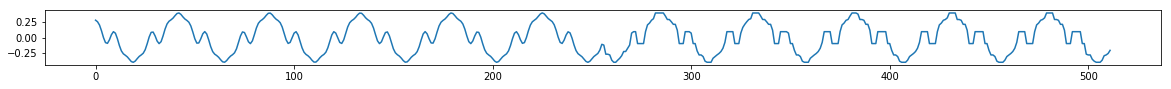

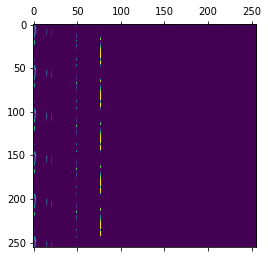

2018-11-19 23:27:20 Epoch [1/1], Step [875/19500] Loss: 2.5578
2018-11-19 23:28:36 Epoch [1/1], Step [900/19500] Loss: 2.5762


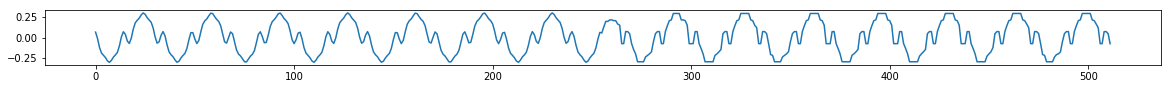

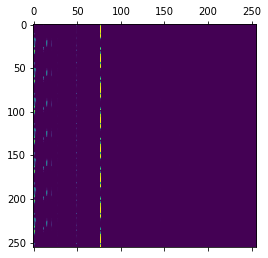

2018-11-19 23:29:55 Epoch [1/1], Step [925/19500] Loss: 2.5510
2018-11-19 23:31:11 Epoch [1/1], Step [950/19500] Loss: 2.4872


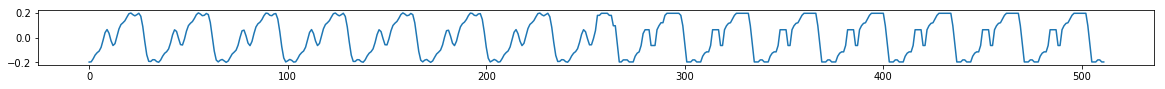

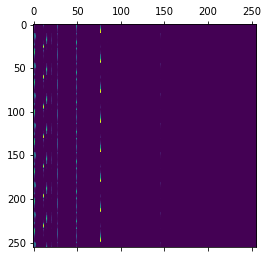

2018-11-19 23:32:30 Epoch [1/1], Step [975/19500] Loss: 2.5157
2018-11-19 23:33:46 Epoch [1/1], Step [1000/19500] Loss: 2.4539


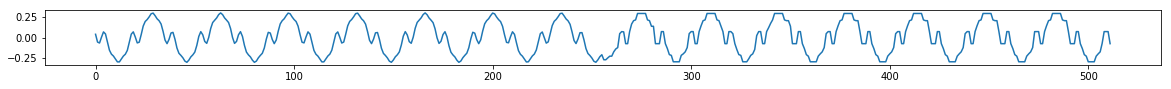

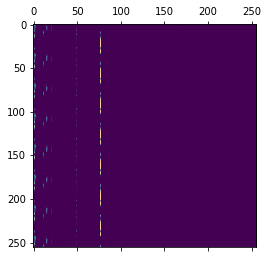

Training time taken: 0:51:45
encoder saved at epoch1


NameError: name 'step' is not defined

In [11]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(encoder,decoder,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if savemodel_interval == 0 and savemodel:
    torch.save(encoder.state_dict(), 
       '{}/{:%Y-%m-%d_%H-%M-%S}_encoder_epoch{}.pth'.format(savemodeldir,datetime.now(),epoch+1))
    print('encoder saved at epoch{}'.format(epoch+1))
    torch.save(decoder.state_dict(), 
       '{}/{:%Y-%m-%d_%H-%M-%S}_decoder_epoch{}.pth'.format(savemodeldir,datetime.now(),epoch+1))
    print('decoder saved at epoch{}'.format(epoch+1))

In [12]:
    torch.save(encoder.state_dict(), 
       '{}/{:%Y-%m-%d_%H-%M-%S}_encoder_epoch{}.pth'.format(savemodeldir,datetime.now(),epoch+1))
    print('encoder saved at epoch{}'.format(epoch+1))
    torch.save(decoder.state_dict(), 
       '{}/{:%Y-%m-%d_%H-%M-%S}_decoder_epoch{}.pth'.format(savemodeldir,datetime.now(),epoch+1))
    print('decoder saved at epoch{}'.format(epoch+1))

encoder saved at epoch1
decoder saved at epoch1


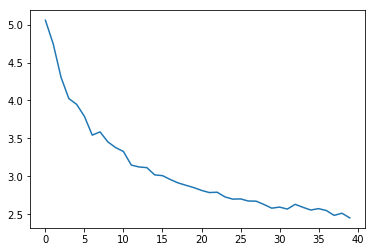

In [13]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)